# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

***Описание данных***

**Признак**

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата


**Целевой признак**
- Exited — факт ухода клиента


## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve
)

from tqdm import tqdm
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
data = pd.read_csv('/datasets/Churn.csv') #прочитаем csv-файл

In [3]:
data.head() #помотрим первые строки

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
data.columns #перечень названий столбцов

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [6]:
data.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography', 'gender', \
                'age', 'tenure', 'balance', 'num_opf_products', 'has_cr_card', 'is_active_member',\
               'estimated_salary','exited'] # переименование столбцов 

In [7]:
data.isna().sum() #проверка на отсутствие пропусков

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_opf_products      0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

Заполнять средним или медианным значением пропуски в столбце о клиентских годах не будем, чтобы не было искажения данных. Пропуски составляют менее 10%, удалим их.

In [8]:
data.duplicated().sum() #проверим на явные дубликаты

0

In [9]:
data_n = data.drop(columns = ['row_number', 'customer_id', 'surname']).dropna() 
#удалим лишние стоблцы и строки с пропусками
data_n

,credit_score,geography,gender,age,tenure,balance,num_opf_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9994,800,France,Female,29,2.0,0.00,2,0,0,167773.55,0
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1


Переименовала столбцы, удалила строки с пропусками в столбце о клиентских годах (заполнение средним или медианным значением сомнительно), дубликаты не обнаружены.

Удалила столбцы индекса строки в данных, уникального идентификатора клиента, фамилии.

## Исследование задачи

Построим гистограммы оттока клиентов по возрасту, географии и полу

In [10]:
data_n['exited'].value_counts() #посмотрим количество оставшихся и ушедших клиетов

0    7237
1    1854
Name: exited, dtype: int64

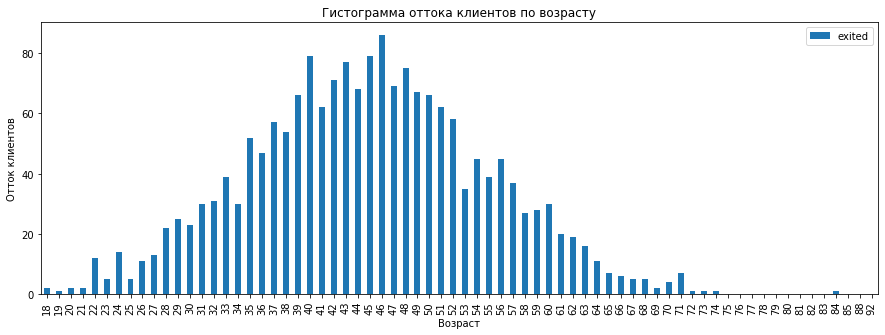

In [11]:
data_n.groupby('age').agg({'exited':'sum'}).plot(kind = 'bar', figsize = (15,5),
                                             title='Гистограмма оттока клиентов по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Отток клиентов')
plt.show()

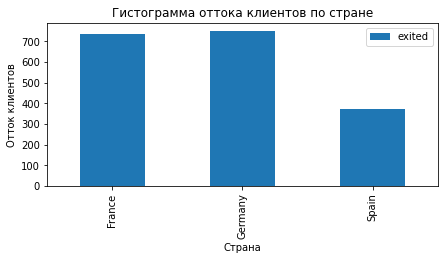

In [12]:
data_n.groupby('geography').agg({'exited':'sum'}).plot(kind = 'bar', figsize = (7,3),
                                              title='Гистограмма оттока клиентов по стране')
plt.xlabel('Страна')
plt.ylabel('Отток клиентов')
plt.show()

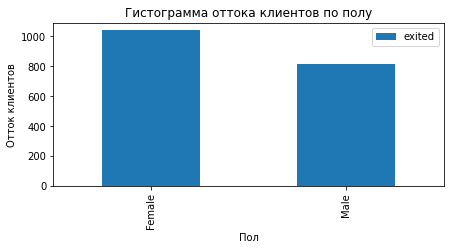

In [13]:
data_n.groupby('gender').agg({'exited':'sum'}).plot(kind = 'bar', figsize = (7,3),
                                              title='Гистограмма оттока клиентов по полу')
plt.xlabel('Пол')
plt.ylabel('Отток клиентов')
plt.show()

Ушедшие клиенты составляют 1/4 от оставшихся.
Наиболее часто уходят клиенты в возрасте от 35 до 52 лет, чаще женщины. 

Если говорить о странах, то Германия на первом месте, с небольшой разницей на втором месте Франция и почти вдвое меньше Испания. 

In [14]:
data_ohe = pd.get_dummies(data_n, drop_first=True) 
#преобразуем категориальные признаки в численные техникой прямого кодирования One-Hot Encoding

In [15]:
data_ohe.head()

,credit_score,age,tenure,balance,num_opf_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Разобъем данные на 3 части: обучающую, валидационную и тестовую (60%, 20% и 20%).

In [16]:
features = data_ohe.drop(['exited'], axis=1)
target = data_ohe['exited']

In [17]:
features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size = 0.4, random_state=12345) #тестовая выборка

In [18]:
features_test, features_valid, target_test, target_valid = \
train_test_split(features_test, target_test, test_size = 0.5, random_state=12345) #валидационная выборка

Посмотрим размеры выборок

In [19]:
features_train.shape, features_test.shape, features_valid.shape

((5454, 11), (1818, 11), (1819, 11))

Стандартизируем данные

In [20]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']

In [21]:
scaler = StandardScaler() #создадим структуру страндартизации данных

In [22]:
scaler.fit(features_train[numeric])
pd.options.mode.chained_assignment = None #добавим, чтобы не было предупреждения SettingWithCopy

In [23]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

***Исследование моделей при дисбалансе***

**Дерево решений**

In [24]:
for depth in range(1, 16):
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dtc.fit(features_train, target_train)
    prediction_valid_dtc = model_dtc.predict(features_valid)
print("Матрица ошибок:", confusion_matrix(target_valid, prediction_valid_dtc))     
print("F1-мера:",f1_score(target_valid, prediction_valid_dtc).round(3))

Матрица ошибок: [[1294  174]
 [ 172  179]]
F1-мера: 0.509


**Случайный лес**

In [25]:
%time
for est in range(10, 171, 10):
    for depth in range(1, 16):
        model_rfc = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_rfc.fit(features_train, target_train)
        prediction_valid_rfc = model_rfc.predict(features_valid)
print("Матрица ошибок:", confusion_matrix(target_valid, prediction_valid_rfc))         
print("F1-мера:",f1_score(target_valid, prediction_valid_rfc).round(3))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs
Матрица ошибок: [[1424   44]
 [ 194  157]]
F1-мера: 0.569


**Логистическая регрессия**

In [26]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_train, target_train)
prediction_valid_lr = model_lr.predict(features_valid)
print("Матрица ошибок:", confusion_matrix(target_valid, prediction_valid_lr))         
print("F1-мера:",f1_score(target_valid, prediction_valid_lr).round(3))

Матрица ошибок: [[1427   41]
 [ 276   75]]
F1-мера: 0.321


----

Построим ROC-кривые для каждой модели

In [27]:
probabilities_dtc = model_dtc.predict_proba(features_valid)
probabilities_one_valid_dtc = probabilities_dtc[:,1]
fpr_dtc,tpr_dtc,thresholds = roc_curve(target_valid,probabilities_one_valid_dtc)

probabilities_rfc = model_rfc.predict_proba(features_valid)
probabilities_one_valid_rfc = probabilities_rfc[:,1]
fpr_rfc,tpr_rfc,thresholds = roc_curve(target_valid,probabilities_one_valid_rfc)

probabilities_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_lr[:,1]
fpr_lr,tpr_lr,thresholds = roc_curve(target_valid,probabilities_one_valid_lr)

print("AUC-ROC")
print("Дерево решений", roc_auc_score(target_valid,probabilities_one_valid_dtc).round(3))
print("Случайный лес", roc_auc_score(target_valid,probabilities_one_valid_rfc).round(3))
print("Логистическая регрессия", roc_auc_score(target_valid,probabilities_one_valid_lr).round(3))

AUC-ROC
Дерево решений 0.703
Случайный лес 0.858
Логистическая регрессия 0.781


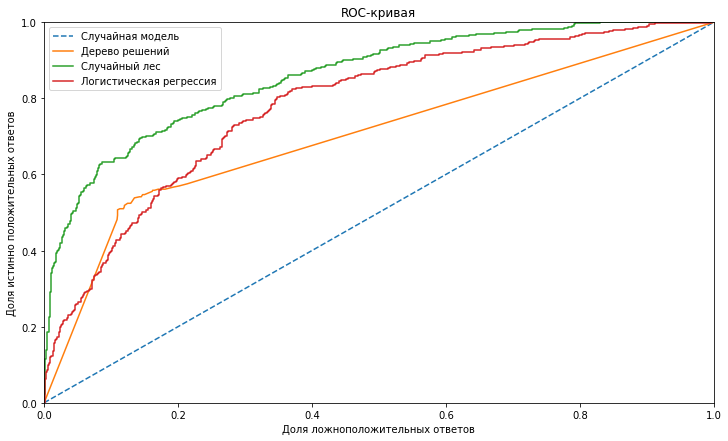

In [28]:
plt.figure(figsize = (12,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_dtc,tpr_dtc)
plt.plot(fpr_rfc,tpr_rfc)
plt.plot(fpr_lr,tpr_lr)
plt.xlabel('Доля ложноположительных ответов')
plt.ylabel('Доля истинно положительных ответов')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Дерево решений','Случайный лес','Логистическая регрессия')) 
plt.show()

<div style="border:solid steelblue 2px; padding: 10px; border-radius: 5px"> 
При построении гистограмм заметили, что ушедшие клиенты составляют 1/4 от оставшихся, наиболее часто уходят клиенты в возрасте от 35 до 52 лет, чаще женщины.
Если говорить о странах, то Германия на первом месте, с небольшой разницей на втором месте Франция и почти вдвое меньше Испания.

Исследование моделей при дисбалансе показало 

F1:
- дерево решений 0.509
- случайный лес 0.569
- логистическая регрессия 0.321

AUC-ROC: 
- дерево решений 0.703
- случайный лес 0.858
- логистическая регрессия 0.781

## Борьба с дисбалансом

Придадим редким объектам больший вес, есть 3 способа: взвешивание классов, увеличение и уменьшение выборки. 

### Взвешивание классов

**Дерево решений**

In [29]:
for depth in range(1, 16):
    model_dtc_b = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_dtc_b.fit(features_train, target_train)
    prediction_valid_dtc_b = model_dtc_b.predict(features_valid)
print("F1-мера:",f1_score(target_valid, prediction_valid_dtc_b).round(3))

F1-мера: 0.489


**Случайный лес**

In [30]:
%%time
for est in range(10, 171, 10):
    for depth in range(1, 16):
        model_rfc_b = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model_rfc_b.fit(features_train, target_train)
        prediction_valid_rfc_b = model_rfc_b.predict(features_valid)
print("F1-мера:",f1_score(target_valid, prediction_valid_rfc_b).round(3))

F1-мера: 0.584
CPU times: user 1min 55s, sys: 463 ms, total: 1min 56s
Wall time: 1min 56s


**Логистическая регрессия**

In [31]:
model_lr_b = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_lr_b.fit(features_train, target_train)
prediction_valid_lr_b = model_lr_b.predict(features_valid)
print("F1:", f1_score(target_valid, prediction_valid_lr_b).round(3))

F1: 0.503


### Увеличение выборки

In [32]:
def upsample(features, target, repeat): #объявим переменные
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    repeat = 4 #количество повторений
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=12345) #перемешаем данные
    

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Обучим модели на новых данных

In [33]:
for depth in range(1, 16):
    model_dtc_up = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dtc_up.fit(features_upsampled, target_upsampled)
    prediction_valid_dtc_up = model_dtc_up.predict(features_valid)
print("F1-мера модели дерево решений на увеличенной выборке:",f1_score(target_valid, prediction_valid_dtc_up).round(3))

F1-мера модели дерево решений на увеличенной выборке: 0.487


In [34]:
%%time
model_b = None
best_depth = 0
best_est = 0
best_f1 = 0
for est in range(10, 171, 10):
    for depth in range(1, 16):
        model_rfc_up = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_rfc_up.fit(features_upsampled, target_upsampled)
        prediction_valid_rfc_up = model_rfc_up.predict(features_valid)
        f1 = f1_score(target_valid, prediction_valid_rfc_up)
        if f1 > best_f1:
            model_b = model_rfc_up
            best_depth = depth
            best_est = est
            best_f1 = f1           
print("Лучшие показатели модели случайный лес на увеличенной выборке")
print("Модель", model_b)
print("Глубина", best_depth)
print("Количество деревьев", best_est)
print("F1-мера",f1.round(3))

Лучшие показатели модели случайный лес на увеличенной выборке
Модель RandomForestClassifier(max_depth=15, n_estimators=130, random_state=12345)
Глубина 15
Количество деревьев 130
F1-мера 0.609
CPU times: user 2min 38s, sys: 484 ms, total: 2min 39s
Wall time: 2min 39s


In [35]:
model_lr_up = LogisticRegression(random_state=12345, solver='liblinear')
model_lr_up.fit(features_upsampled, target_upsampled)
prediction_valid_lr_up = model_lr_up.predict(features_valid)
print("F1-мера модели логистическая регрессия на увеличенной выборке:", f1_score(target_valid, prediction_valid_lr_up).round(3))

F1-мера модели логистическая регрессия на увеличенной выборке: 0.498


### Уменьшение выборки

In [36]:
def downsample(features, target, fraction): #объявим переменные
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    fraction = 0.25
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

Обучим модели на новых данных

In [37]:
for depth in range(1, 16):
    model_dtc_dn = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dtc_dn.fit(features_downsampled, target_downsampled)
    prediction_valid_dtc_dn = model_dtc_dn.predict(features_valid)
print("F1-мера модели дерево решений на уменьшенной выборке:",f1_score(target_valid, prediction_valid_dtc_dn).round(3))

F1-мера модели дерево решений на уменьшенной выборке: 0.502


In [38]:
%%time
for est in range(10, 171, 10):
    for depth in range(1, 16):
        model_rfc_dn = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_rfc_dn.fit(features_downsampled, target_downsampled)
        prediction_valid_rfc_dn = model_rfc_dn.predict(features_valid)
print("F1-мера модели cлучайнай лес на уменьшенной выборке:",f1_score(target_valid, prediction_valid_rfc_dn).round(3))

F1-мера модели cлучайнай лес на уменьшенной выборке: 0.559
CPU times: user 1min 10s, sys: 396 ms, total: 1min 10s
Wall time: 1min 10s


In [39]:
model_lr_dn = LogisticRegression(random_state=12345, solver='liblinear')
model_lr_dn.fit(features_downsampled, target_downsampled)
prediction_valid_lr_dn = model_lr_dn.predict(features_valid)
print("F1-мера модели логистическая регрессия на увеличенной выборке:", f1_score(target_valid, prediction_valid_lr_dn).round(3))

F1-мера модели логистическая регрессия на увеличенной выборке: 0.491


**F1 моделей при балансировке классов:**

   * дерево решений 
    - взвешивание классов 0.489
    - увеличение выборки 0.487
    - уменьшение выборки 0.502
    
    
   * случайный лес 
    - взвешивание классов 0.584
    - увеличение выборки 0.609
    - уменьшение выборки 0.559
    
    
   * логистическая регрессия 
    - взвешивание классов 0.503
    - увеличение выборки 0.498
    - уменьшение выборки 0.491
    
    
***Лучшие показатели у модели случайный лес на увеличенной выборке: глубина 15, количество деревьев 130, F1-мера 0.609***
    
    

### Обучим модель на объединенных тренировочной и валидационной выборках

**Модель случайный лес после балансировки классов методом увеличение выборки**

In [40]:
features_train_valid = pd.concat((features_train, features_valid), axis=0)
target_train_valid = pd.concat((target_train, target_valid), axis=0)
features_train_valid.shape, target_train_valid.shape #посмотрим размер объединенной выборки

((7273, 11), (7273,))

In [41]:
best_model = model_rfc_up.fit(features_train_valid, target_train_valid) #переименуем и обучим модель

## Тестирование модели

Протестируем модель случайный лес на объединенных тренировочной и валидационной выборках после балансировки методом увеличение выборки

In [42]:
prediction_best_model = best_model.predict(features_test)
print("F1-мера:",f1_score(target_test, prediction_best_model))

F1-мера: 0.59


### AUC-ROC

Посмотрим как сильно модель случайный лес отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC метрика

Метрика AUC-ROC 0.8712809959190585


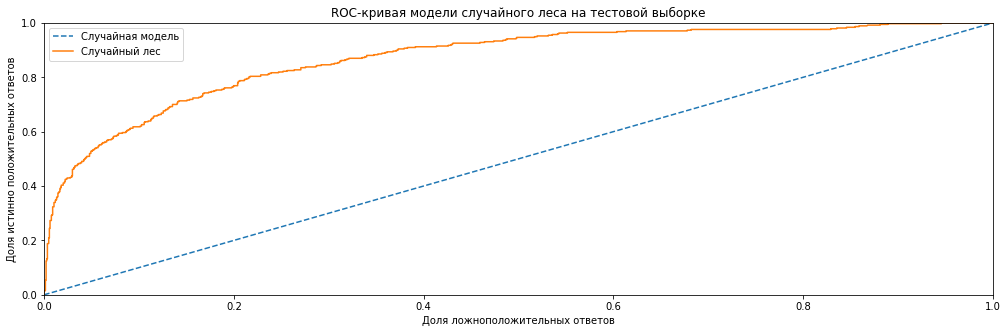

In [43]:
probabilities = best_model.predict_proba(features_test)
probabilities_one_test = probabilities[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc =  roc_auc_score(target_test, probabilities_one_test)
print("Метрика AUC-ROC",auc_roc)

plt.figure(figsize = (17,5))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.plot(fpr, tpr) #построим график
plt.xlabel('Доля ложноположительных ответов')
plt.ylabel('Доля истинно положительных ответов')
plt.title('ROC-кривая модели случайного леса на тестовой выборке')
plt.legend(('Случайная модель', 'Случайный лес'))
plt.show()

<div class="alert-info" style="padding: 20px; border-radius: 10px"> 
<b>Вывод</b>
    
Была выполнена предобработка данных. Переименовала столбцы, удалила строки с пропусками в столбце о клиентских годах (заполнение средним или медианным значением сомнительно), дубликаты не обнаружены. Удалила столбцы индекса строки в данных, уникального идентификатора клиента, фамилии.
    
При построении гистограмм заметили, что ушедшие клиенты составляют 1/4 от оставшихся, наиболее часто уходят клиенты в возрасте от 35 до 52 лет, чаще женщины.
Если говорить о странах, то Германия на первом месте, с небольшой разницей на втором месте Франция и почти вдвое меньше Испания.

Исследование моделей при дисбалансе показало 

F1:
- дерево решений 0.556
- случайный лес 0.558
- логистическая регрессия 0.321

AUC-ROC: 
- дерево решений 0.703
- случайный лес 0.858
- логистическая регрессия 0.781

При дисбалансе высокие F-1 и AUC-ROC у модели случайный лес.
    
После балансировки классов лучший показатель у модели случайный лес на увеличенной выборке: глубина 15, количество деревьев 130, F1-мера 0.609.  
Эту модель обучили на объединенных тренировочной и валидационной выборках.
    
Тестирование этой модели показало F1-меру 0.59, метрику AUC-ROC 0.87. 

Модель успешно прошла проверку на адекватность. <div>